# BRITISH AIRWAYS - CUSTOMER BOOKING DATA

In [1]:
# Import libraries
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.express as px

In [2]:
# Read Dataset CSV file
df = pd.read_csv("/Users/nikitaakenkre/Downloads/customer_booking.csv", encoding='latin1')
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


# Exploratory Data Analysis

In [44]:
# Check for unique values for all columns to understand how data can be cleaned and processed
distinct_values_counts = df.nunique()

print(distinct_values_counts)

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64


In [45]:
# Get distinct values for specific columns
sales_channel_values = df['sales_channel'].unique()
trip_type_values = df['trip_type'].unique()

print("Distinct values for 'sales_channel':", sales_channel_values)
print("Distinct values for 'trip_type':", trip_type_values)

Distinct values for 'sales_channel': ['Internet' 'Mobile']
Distinct values for 'trip_type': ['RoundTrip' 'CircleTrip' 'OneWay']


In [5]:
# Get the count of 1s and 0s in the booking_complete column
booking_complete_counts = df['booking_complete'].value_counts()

# Calculate the ratio of 0s to 1s
ratio = booking_complete_counts[0] / booking_complete_counts[1]

print("Count of '1's and '0's in booking_complete column:")
print(booking_complete_counts)
print("Ratio of 0s to 1s in booking_complete column:", ratio)

Count of '1's and '0's in booking_complete column:
booking_complete
0    42522
1     7478
Name: count, dtype: int64
Ratio of 0s to 1s in booking_complete column: 5.6862797539449055


# Problem Statement - We can see that about 1 in 5 people who view the British Airways website, end up NOT booking a flight, and this is the problem we plan to solve

# Further EDA to understand the nature of the dataset in more depth.

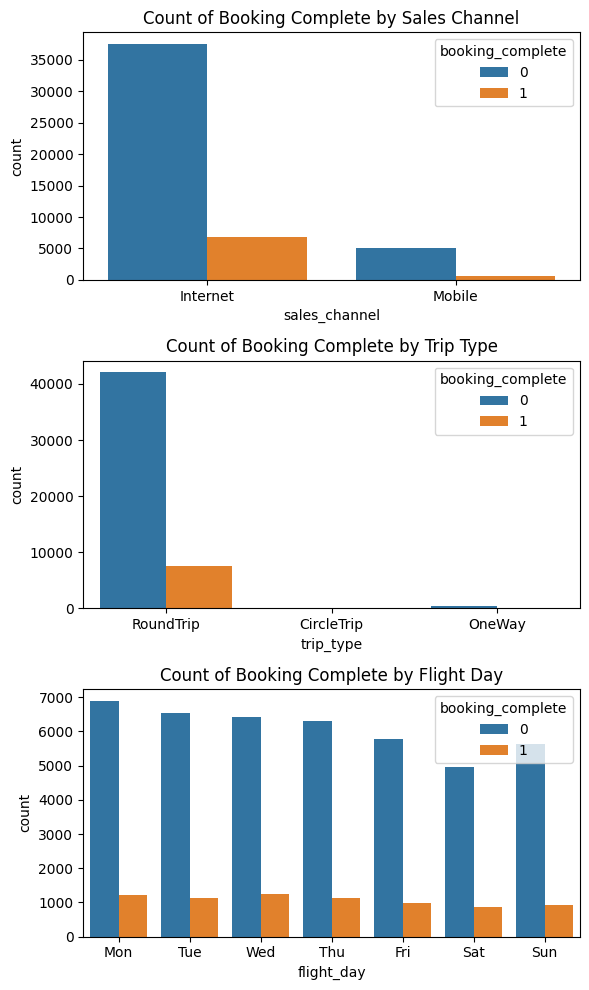

In [49]:
# Set the order of days for flight_day
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))

# Plot count plots for sales_channel, trip_type, and flight_day
sns.countplot(x='sales_channel', hue='booking_complete', data=df, ax=axes[0])
axes[0].set_title('Count of Booking Complete by Sales Channel')

sns.countplot(x='trip_type', hue='booking_complete', data=df, ax=axes[1])
axes[1].set_title('Count of Booking Complete by Trip Type')

sns.countplot(x='flight_day', hue='booking_complete', data=df, ax=axes[2], order=day_order)
axes[2].set_title('Count of Booking Complete by Flight Day')

# Adjust layout
plt.tight_layout()
plt.show()

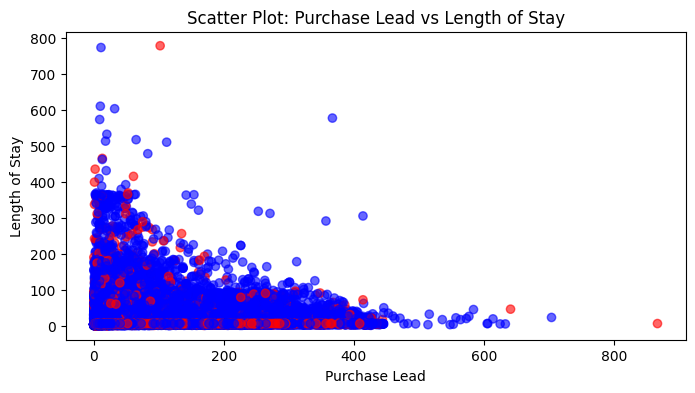

In [7]:
# Define colors for booking_complete: 0 (blue) and 1 (red)
colors = ['blue' if c == 0 else 'red' for c in df['booking_complete']]

# Scatter plot between purchase_lead and length_of_stay
plt.figure(figsize=(8, 4))
plt.scatter(df['purchase_lead'], df['length_of_stay'], c=colors, alpha=0.6)
plt.xlabel('Purchase Lead')
plt.ylabel('Length of Stay')
plt.title('Scatter Plot: Purchase Lead vs Length of Stay')
plt.show()


# Pre-processing the Dataset for Model Training and Development

### Next we want to narrow down the dataset to the target consumers for British Airways

In [50]:
# Total number of people who want in-flight meals
total_meals = df['wants_in_flight_meals'].sum()

# Total number of people who want preferred seats
total_preferred_seats = df['wants_preferred_seat'].sum()

# Total number of people who want extra baggage
total_extra_baggage = df['wants_extra_baggage'].sum()

# Display the totals
print("Total number of people who want in-flight meals:", total_meals)
print("Total number of people who want preferred seats:", total_preferred_seats)
print("Total number of people who want extra baggage:", total_extra_baggage)

Total number of people who want in-flight meals: 21357
Total number of people who want preferred seats: 14848
Total number of people who want extra baggage: 33439


In [51]:
# Filter the DataFrame to include only rows where all three conditions are met
all_three_df = df[(df['wants_in_flight_meals'] == 1) & 
                  (df['wants_preferred_seat'] == 1) & 
                  (df['wants_extra_baggage'] == 1) & 
                  (df['booking_complete'] == 1)]

# Count the number of rows in the filtered DataFrame
total_all_three = len(all_three_df)

# Display the total
print("Total number of people who want all three amenities and have completed bookings:", total_all_three)

Total number of people who want all three amenities and have completed bookings: 1631


In [10]:
# Group by 'purchase_lead' and calculate the total number of 'booking_complete' for purchase_lead
route_counts = df.groupby('purchase_lead')['booking_complete'].sum()

# Sort the  purchase_lead based on the total number of 'booking_complete'
sorted_routes = route_counts.sort_values()

# Get the top 20 and bottom 20 purchase_lead days
top_20_routes = sorted_routes.tail(30)
bottom_20_routes = sorted_routes.head(30)

# Print the top 30 purchase_lead with the highest number of 'booking_complete'
print("Top 30 purchase_lead with the highest number of booking_complete:")
print(top_20_routes)

# Print the bottom 30 purchase_lead with the lowest number of 'booking_complete'
print("\nBottom 30 purchase_lead with the lowest number of booking_complete:")
print(bottom_20_routes)

Top 30 purchase_lead with the highest number of booking_complete:
purchase_lead
50     69
47     69
28     69
25     70
46     71
26     74
18     75
29     76
22     79
23     80
11     83
21     83
16     86
14     87
19     91
17     92
5      96
1     102
10    103
12    104
9     104
20    107
8     108
15    111
3     114
13    117
6     118
2     120
4     121
7     122
Name: booking_complete, dtype: int64

Bottom 30 purchase_lead with the lowest number of booking_complete:
purchase_lead
302    0
334    0
443    0
315    0
305    0
397    0
433    0
432    0
349    0
426    0
445    0
423    0
419    0
418    0
413    0
412    0
411    0
382    0
384    0
405    0
704    0
421    0
446    0
398    0
460    0
605    0
577    0
573    0
606    0
564    0
Name: booking_complete, dtype: int64


In [39]:
df_filtered = df[df['purchase_lead'] <= 150]
df_filtered

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
5,1,Internet,RoundTrip,3,48,20,Thu,AKLDEL,New Zealand,1,0,1,5.52,0
8,1,Internet,RoundTrip,80,22,4,Mon,AKLDEL,New Zealand,0,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


In [12]:
# Get the count of 1s and 0s in the booking_complete column
booking_complete_counts = df_filtered['booking_complete'].value_counts()
booking_complete_counts

booking_complete
0    34524
1     6191
Name: count, dtype: int64

In [13]:
# Group by 'route' and calculate the total number of 'booking_complete' for each route
route_counts = df_filtered.groupby('route')['booking_complete'].sum()

# Sort the routes based on the total number of 'booking_complete'
sorted_routes = route_counts.sort_values()

# Get the top 20 and bottom 20 routes
top_20_routes = sorted_routes.tail(20)
bottom_20_routes = sorted_routes.head(20)

# Print the top 20 routes with the highest number of 'booking_complete'
print("Top 20 routes with the highest number of booking_complete:")
print(top_20_routes)

# Print the bottom 20 routes with the lowest number of 'booking_complete'
print("\nBottom 20 routes with the lowest number of booking_complete:")
print(bottom_20_routes)


Top 20 routes with the highest number of booking_complete:
route
SGNSYD     56
PENSYD     61
CTSDMK     62
CGKHND     64
BKIICN     66
PENPER     69
KIXPEN     70
DPSPVG     73
CGKKIX     77
KTMMFM     77
PENPVG     77
ICNSIN     82
HNDPEN     88
ICNPEN    117
KTMPEN    117
MELPEN    123
DMKKIX    138
JHBKTM    163
PENTPE    349
AKLKUL    372
Name: booking_complete, dtype: int64

Bottom 20 routes with the lowest number of booking_complete:
route
AKLDEL    0
ICNJED    0
ICNIKA    0
HYDWUH    0
HYDMRU    0
HNDTRZ    0
HNDSBW    0
HNDOOL    0
HNDMLE    0
HNDMAA    0
HNDLOP    0
HNDKTM    0
HNDIKA    0
HKTPUS    0
HKTMRU    0
HKTKTM    0
HKTJED    0
HKTIKA    0
HKGKTM    0
HKGJED    0
Name: booking_complete, dtype: int64


In [14]:
# Calculate the total count of each route in the DataFrame
route_total_counts = df_filtered['route'].value_counts()

# Calculate the count of 'booking_complete' = 1 and 'booking_complete' = 0 for each route
route_booking_counts = df_filtered.groupby(['route', 'booking_complete']).size().unstack(fill_value=0)

# Merge the route_total_counts DataFrame with the route_booking_counts DataFrame
merged_df = pd.merge(route_total_counts, route_booking_counts, left_index=True, right_index=True)

# Rename the columns for clarity
merged_df.columns = ['Total Count of Route', 'Booking Complete', 'Booking Incomplete']

# Calculate the ratio of 'Booking Complete' to 'Booking Incomplete' for each route
merged_df['Ratio'] = merged_df['Booking Complete'] / merged_df['Booking Incomplete']

# Print the resulting DataFrame
print(merged_df)


        Total Count of Route  Booking Complete  Booking Incomplete       Ratio
route                                                                         
AKLKUL                  1689              1317                 372    3.540323
PENTPE                   806               457                 349    1.309456
MELSGN                   695               653                  42   15.547619
ICNSIN                   668               586                  82    7.146341
ICNSYD                   590               585                   5  117.000000
...                      ...               ...                 ...         ...
CKGSBW                     1                 1                   0         inf
LBUTPE                     1                 1                   0         inf
CMBWUH                     1                 1                   0         inf
SYDVTZ                     1                 1                   0         inf
MRUXIY                     1                 1      

In [15]:
# Count the occurrences of infinite values in the 'Ratio' column
inf_count = np.sum(np.isinf(merged_df['Ratio']))

# Print the count of infinite values
print("Count of infinite values in the 'Ratio' column:", inf_count)


Count of infinite values in the 'Ratio' column: 250


In [16]:
# Filter the DataFrame to include only the rows where the 'Ratio' column has an infinite value
inf_rows = merged_df[np.isinf(merged_df['Ratio'])]

# Get the corresponding 'booking_complete' value for these rows
corresponding_booking_complete = inf_rows['Booking Complete']

# Print the corresponding 'booking_complete' value
print("Corresponding 'booking_complete' value for ratio = inf:")
print(corresponding_booking_complete)

Corresponding 'booking_complete' value for ratio = inf:
route
DELSYD    163
IKASYD     90
REPTPE     67
HKTPUS     64
IKAOOL     63
         ... 
CKGSBW      1
LBUTPE      1
CMBWUH      1
SYDVTZ      1
MRUXIY      1
Name: Booking Complete, Length: 250, dtype: int64


In [17]:
# Filter the DataFrame based on the conditions
filtered_df = merged_df[(np.isinf(merged_df['Ratio'])) & (merged_df['Total Count of Route'] <= 30)]

# Count the number of rows in the filtered DataFrame
count_inf_and_total_30 = len(filtered_df)

# Print the count
print("Count of Ratio = inf and Total Count of Route <= 30:", count_inf_and_total_30)

Count of Ratio = inf and Total Count of Route <= 30: 233


In [18]:
# Get the routes corresponding to ratio = inf and total count of route <= 30
routes_to_remove = filtered_df.index.tolist()

# Remove the routes from df_filtered
df_filtered = df_filtered[~df_filtered['route'].isin(routes_to_remove)]

df_filtered

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
21,1,Internet,RoundTrip,21,88,9,Wed,AKLICN,South Korea,1,0,1,6.62,0
22,2,Internet,RoundTrip,23,19,8,Mon,AKLICN,New Zealand,1,0,1,6.62,0
23,2,Internet,RoundTrip,25,27,13,Fri,AKLICN,South Korea,1,0,1,6.62,0
24,1,Internet,RoundTrip,16,21,6,Thu,AKLICN,New Zealand,1,0,1,6.62,0
25,1,Internet,RoundTrip,66,20,7,Thu,AKLICN,South Korea,1,0,0,6.62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


In [19]:
# Filter the DataFrame to include only rows where 'booking_complete' is 1
completed_bookings_df = df_filtered[df_filtered['booking_complete'] == 1]

# Get the top 10 countries with the highest bookings
top_countries = completed_bookings_df['booking_origin'].value_counts().head(10)

# Display the top 10 countries
print("Top 10 countries with the highest bookings:")
print(top_countries)

Top 10 countries with the highest bookings:
booking_origin
Malaysia       1961
Australia       812
China           601
Indonesia       443
Japan           436
South Korea     381
Thailand        332
Singapore       259
Taiwan          209
India           112
Name: count, dtype: int64


In [20]:
# Filter the DataFrame to include only rows where 'booking_complete' is 1
incompleted_bookings_df = df[df['booking_complete'] == 0]

# Get the top 10 countries with the highest bookings
top_countries = incompleted_bookings_df['booking_origin'].value_counts().head(10)

# Display the top 10 countries
print("Bottom 10 countries with the highest incomplete bookings:")
print(top_countries)

Bottom 10 countries with the highest incomplete bookings:
booking_origin
Australia      16972
Malaysia        4706
South Korea     4097
Japan           3407
China           2693
Taiwan          1853
Indonesia       1754
Thailand        1560
India           1139
New Zealand     1020
Name: count, dtype: int64


In [21]:
# Calculate the total count of each booking origin in the DataFrame
origin_total_counts = df_filtered['booking_origin'].value_counts()

# Calculate the count of 'booking_complete' = 1 and 'booking_complete' = 0 for each booking origin
origin_booking_counts = df_filtered.groupby(['booking_origin', 'booking_complete']).size().unstack(fill_value=0)

# Merge the origin_total_counts DataFrame with the origin_booking_counts DataFrame
merged_origin_df = pd.merge(origin_total_counts, origin_booking_counts, left_index=True, right_index=True)

# Rename the columns for clarity
merged_origin_df.columns = ['Total Count of Booking Origin', 'Booking Complete', 'Booking Incomplete']

# Calculate the ratio of 'Booking Complete' to 'Booking Incomplete' for each booking origin
merged_origin_df['Ratio'] = merged_origin_df['Booking Complete'] / merged_origin_df['Booking Incomplete']

merged_origin_df

,Total Count of Booking Origin,Booking Complete,Booking Incomplete,Ratio
booking_origin,,,,
Australia,14554,13742,812,16.923645
Malaysia,5585,3624,1961,1.848037
South Korea,3570,3189,381,8.370079
Japan,3153,2717,436,6.231651
China,2731,2130,601,3.544093
...,...,...,...,...
Bulgaria,1,1,0,inf
Cyprus,1,1,0,inf
Slovakia,1,1,0,inf


In [22]:
# Count the occurrences of infinite values in the 'Ratio' column for booking origin
inf_count_origin = np.sum(np.isinf(merged_origin_df['Ratio']))

# Print the count of infinite values for booking origin
print("Count of infinite values in the 'Ratio' column for booking origin:", inf_count_origin)

# Filter the DataFrame to include only the rows where the 'Ratio' column has an infinite value for booking origin
inf_rows_origin = merged_origin_df[np.isinf(merged_origin_df['Ratio'])]

# Get the corresponding 'booking_complete' value for these rows for booking origin
corresponding_booking_complete_origin = inf_rows_origin['Booking Complete']

# Print the corresponding 'booking_complete' value for booking origin
print("Corresponding 'booking_complete' value for ratio = inf for booking origin:")
print(corresponding_booking_complete_origin)

# Filter the DataFrame based on the conditions for booking origin
filtered_df_origin = merged_origin_df[(np.isinf(merged_origin_df['Ratio'])) & (merged_origin_df['Total Count of Booking Origin'] <= 50)]

# Count the number of rows in the filtered DataFrame for booking origin
count_inf_and_total_100_origin = len(filtered_df_origin)

# Print the count for booking origin
print("Count of Ratio = inf and Total Count of Booking Origin <= 50 for booking origin:", count_inf_and_total_100_origin)

Count of infinite values in the 'Ratio' column for booking origin: 43
Corresponding 'booking_complete' value for ratio = inf for booking origin:
booking_origin
Réunion                 9
Mongolia                8
Poland                  7
Finland                 7
Ireland                 7
Brazil                  5
Argentina               5
Colombia                4
Maldives                4
Iran                    4
Austria                 4
Ukraine                 3
Peru                    3
New Caledonia           3
Hungary                 2
Solomon Islands         2
Belgium                 2
South Africa            2
Guam                    2
Timor-Leste             2
Slovenia                2
Israel                  2
Tunisia                 2
Czechia                 1
Belarus                 1
Ghana                   1
Guatemala               1
Algeria                 1
Estonia                 1
Tanzania                1
Paraguay                1
Papua New Guinea        1
Egypt   

In [23]:
# Get the origins corresponding to ratio = inf and total count of booking origin <= 50
origins_to_remove = filtered_df_origin.index.tolist()

# Remove the origins from df_filtered
df_filtered = df_filtered[~df_filtered['booking_origin'].isin(origins_to_remove)]

df_filtered

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
21,1,Internet,RoundTrip,21,88,9,Wed,AKLICN,South Korea,1,0,1,6.62,0
22,2,Internet,RoundTrip,23,19,8,Mon,AKLICN,New Zealand,1,0,1,6.62,0
23,2,Internet,RoundTrip,25,27,13,Fri,AKLICN,South Korea,1,0,1,6.62,0
24,1,Internet,RoundTrip,16,21,6,Thu,AKLICN,New Zealand,1,0,1,6.62,0
25,1,Internet,RoundTrip,66,20,7,Thu,AKLICN,South Korea,1,0,0,6.62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


In [24]:
# Find the maximum and minimum length_of_stay
max_length_of_stay = df_filtered['length_of_stay'].max()
min_length_of_stay = df_filtered['length_of_stay'].min()

# Print the results
print("Maximum length_of_stay:", max_length_of_stay)
print("Minimum length_of_stay:", min_length_of_stay)

Maximum length_of_stay: 778
Minimum length_of_stay: 0


In [25]:
# Filter the DataFrame for length_of_stay > 90
length_of_stay_gt_90 = df_filtered[df_filtered['length_of_stay'] > 90]

# Count the occurrences of booking_complete = 0 and 1 for length_of_stay > 90
booking_complete_gt_90 = length_of_stay_gt_90['booking_complete'].value_counts()

# Filter the DataFrame for length_of_stay <= 90
length_of_stay_lte_90 = df_filtered[df_filtered['length_of_stay'] <= 90]

# Count the occurrences of booking_complete = 0 and 1 for length_of_stay <= 90
booking_complete_lte_90 = length_of_stay_lte_90['booking_complete'].value_counts()

# Print the results
print("For length_of_stay > 90:")
print(booking_complete_gt_90)

print("\nFor length_of_stay <= 90:")
print(booking_complete_lte_90)


For length_of_stay > 90:
booking_complete
0    1172
1     180
Name: count, dtype: int64

For length_of_stay <= 90:
booking_complete
0    31844
1     6011
Name: count, dtype: int64


In [26]:
# Filter the DataFrame to remove values where length_of_stay > 90
df_filtered = df_filtered[df_filtered['length_of_stay'] <= 90]

In [27]:
# Find the maximum and minimum flight_duration
max_flight_duration = df_filtered['flight_duration'].max()
min_flight_duration = df_filtered['flight_duration'].min()

# Print the results
print("Maximum flight_duration:", max_flight_duration)
print("Minimum flight_duration:", min_flight_duration)

Maximum flight_duration: 9.5
Minimum flight_duration: 4.67


In [28]:
# Filter the DataFrame for flight_duration > 5
flight_duration_gt_5 = df_filtered[df_filtered['flight_duration'] > 5]

# Count the occurrences of booking_complete = 0 and 1 for flight_duration > 5
booking_complete_gt_5 = flight_duration_gt_5['booking_complete'].value_counts()

# Filter the DataFrame for flight_duration <= 5
flight_duration_lte_5 = df_filtered[df_filtered['flight_duration'] <= 5]

# Count the occurrences of booking_complete = 0 and 1 for flight_duration <= 5
booking_complete_lte_5 = flight_duration_lte_5['booking_complete'].value_counts()

# Print the results
print("For flight_duration > 5:")
print(booking_complete_gt_5)

print("\nFor flight_duration <= 5:")
print(booking_complete_lte_5)

For flight_duration > 5:
booking_complete
0    29034
1     4883
Name: count, dtype: int64

For flight_duration <= 5:
booking_complete
0    2810
1    1128
Name: count, dtype: int64


In [29]:
# Filter the DataFrame to remove values where flight_duration >= 5
df_filtered = df_filtered[df_filtered['flight_duration'] >= 5]

# Feature Importance

#### It is very important to understand which features play higher role in prediction of the target variable 

In [30]:
# Define categorical columns
categorical_columns = ['route',	'booking_origin','flight_day', 'sales_channel', 'trip_type']  # Add other categorical columns as needed
encoders = {}

# Encode categorical columns
for col in categorical_columns:
    label_encoder = LabelEncoder()
    df_filtered[col] = label_encoder.fit_transform(df_filtered[col])
    encoders[col] = label_encoder

# Now the categorical columns are label encoded
df_filtered

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
21,1,0,2,21,88,9,6,0,43,1,0,1,6.62,0
22,2,0,2,23,19,8,1,0,31,1,0,1,6.62,0
23,2,0,2,25,27,13,0,0,43,1,0,1,6.62,0
24,1,0,2,16,21,6,4,0,31,1,0,1,6.62,0
25,1,0,2,66,20,7,4,0,43,1,0,0,6.62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0,2,27,6,9,2,427,1,1,0,1,5.62,0
49996,1,0,2,111,6,4,3,427,1,0,0,0,5.62,0
49997,1,0,2,24,6,22,2,427,1,0,0,1,5.62,0
49998,1,0,2,15,6,11,1,427,1,1,0,1,5.62,0


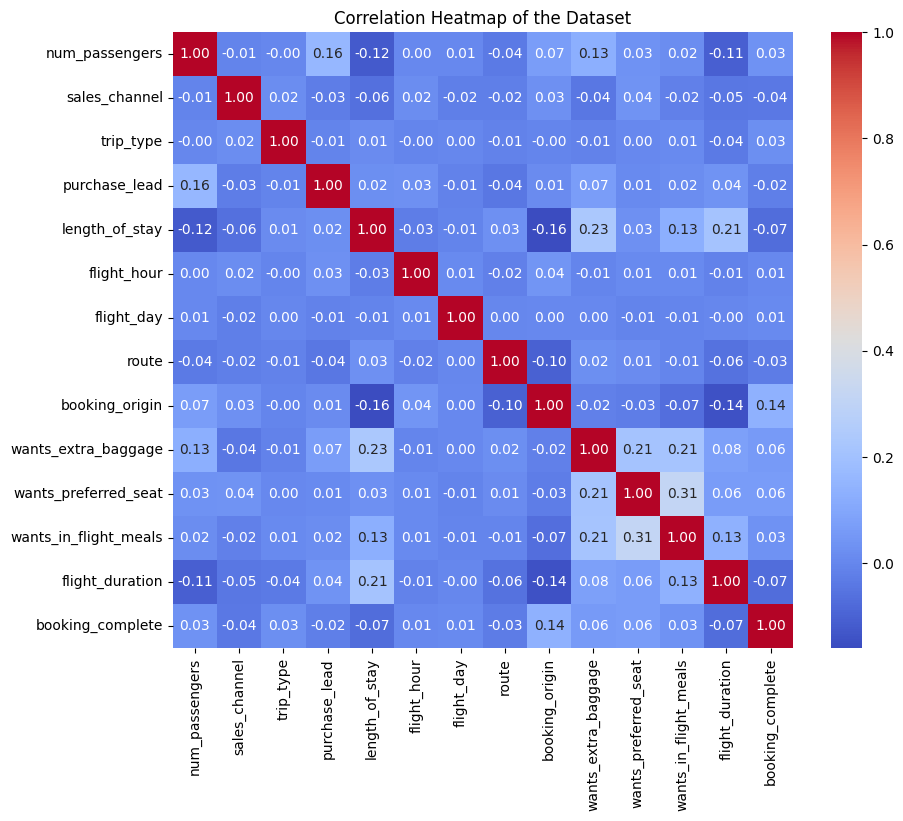

In [31]:
# Exclude non-numeric columns
corr_df = df_filtered.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = corr_df.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of the Dataset')
plt.show()

In [32]:
# Define independent and dependent variables
X = df_filtered.drop(columns=['booking_complete'])  # Independent variables
y = df_filtered['booking_complete']  # Dependent variable

# Initialize RandomForestClassifier
model = RandomForestClassifier()

# Fit the model
model.fit(X, y)

# Get feature importance scores
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance scores
print("Feature Importance Scores:")
print(feature_importance_df)

Feature Importance Scores:
                  Feature  Importance
3           purchase_lead    0.190174
7                   route    0.159084
5             flight_hour    0.141215
4          length_of_stay    0.122603
8          booking_origin    0.113711
6              flight_day    0.091182
12        flight_duration    0.067443
0          num_passengers    0.046836
11  wants_in_flight_meals    0.021654
10   wants_preferred_seat    0.016638
9     wants_extra_baggage    0.015668
1           sales_channel    0.011852
2               trip_type    0.001939


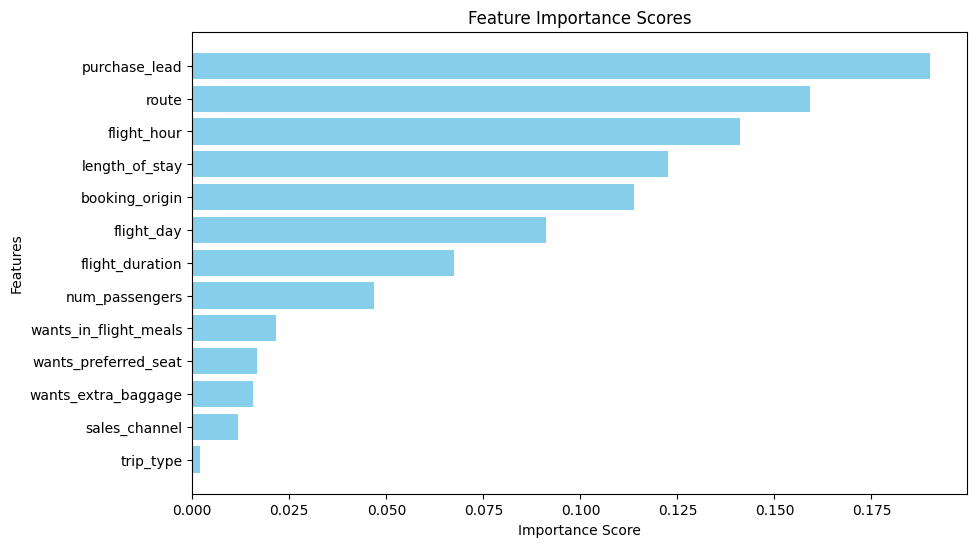

In [33]:
# Plot the feature importance scores
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

# Model Development

In [34]:
columns_to_standardize = df_filtered.columns.difference(['booking_complete'])

# Standardizing the other selected columns
scaler = StandardScaler()
df_filtered[columns_to_standardize] = scaler.fit_transform(df_filtered[columns_to_standardize])
df_filtered

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
21,-0.543259,-0.361517,0.096877,-0.735034,3.512621,-0.004201,1.414738,-1.663147,1.508121,0.707060,-0.669580,1.123917,-0.671002,0
22,0.504191,-0.361517,0.096877,-0.682751,0.001670,-0.190038,-1.021205,-1.663147,0.812489,0.707060,-0.669580,1.123917,-0.671002,0
23,0.504191,-0.361517,0.096877,-0.630468,0.408736,0.739146,-1.508393,-1.663147,1.508121,0.707060,-0.669580,1.123917,-0.671002,0
24,-0.543259,-0.361517,0.096877,-0.865741,0.103436,-0.561712,0.440361,-1.663147,0.812489,0.707060,-0.669580,1.123917,-0.671002,0
25,-0.543259,-0.361517,0.096877,0.441330,0.052553,-0.375875,0.440361,-1.663147,1.508121,0.707060,-0.669580,-0.889745,-0.671002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.504191,-0.361517,0.096877,-0.578186,-0.659814,-0.004201,-0.534016,1.520685,-0.926589,0.707060,-0.669580,1.123917,-1.427798,0
49996,-0.543259,-0.361517,0.096877,1.617693,-0.659814,-0.933386,-0.046827,1.520685,-0.926589,-1.414307,-0.669580,-0.889745,-1.427798,0
49997,-0.543259,-0.361517,0.096877,-0.656610,-0.659814,2.411679,-0.534016,1.520685,-0.926589,-1.414307,-0.669580,1.123917,-1.427798,0
49998,-0.543259,-0.361517,0.096877,-0.891883,-0.659814,0.367473,-1.021205,1.520685,-0.926589,0.707060,-0.669580,1.123917,-1.427798,0


In [35]:
# Define independent and dependent variables
X = df_filtered.drop(columns=['booking_complete'])  # Independent variables
y = df_filtered['booking_complete']  # Dependent variable

In [36]:
# Initialize a random forest classifier
model = RandomForestClassifier(max_depth= 10, random_state=120, n_estimators = 20) # Previously the model was overfitting but after tuning the hyperparameters the overfitting has been resolved

# Initialize stratified cross-validation
stratified_cv = StratifiedKFold(n_splits= 10, shuffle=True)

# Initialize lists to store accuracy and classification reports
train_accuracies = []
test_accuracies = []
reports = []
accs = []
precision_0s = []
precision_1s = []

# Perform stratified cross-validation
for train_index, test_index in stratified_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the testing set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predict on the testing set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    
    # Generate classification report
    report = classification_report(y_test, y_test_pred)
    reports.append(report)

    report_values = [line.split() for line in report.split("\n")]
    accs.append(report_values[5][1])
    precision_0s.append(report_values[2][1])
    precision_1s.append(report_values[3][1])

# Print average accuracy
print("Average Accuracy:", sum(test_accuracies) / len(test_accuracies))

# Print average classification report
print("Classification Report:")
report_df = pd.DataFrame({
    "Model": range(len(accs)),
    "Accuracies": accs,
    "Precision 0": precision_0s,
    "Precision 1": precision_1s,
})
report_df

/Users/nikitaakenkre/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikitaakenkre/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikitaakenkre/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Average Accuracy: 0.8555887756619734
Classification Report:


/Users/nikitaakenkre/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikitaakenkre/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikitaakenkre/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

,Model,Accuracies,Precision 0,Precision 1
0,0,0.86,0.86,0.50
1,1,0.86,0.86,0.00
2,2,0.86,0.86,1.00
3,3,0.86,0.86,0.75
4,4,0.86,0.86,0.67
5,5,0.86,0.86,0.00
6,6,0.86,0.86,1.00
7,7,0.85,0.86,0.00
8,8,0.86,0.86,0.83
9,9,0.86,0.86,0.00


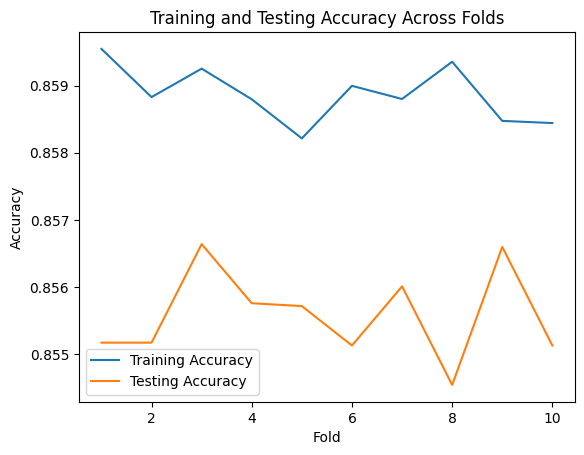

In [37]:
# Plot the accuracy scores
plt.plot(range(1, 11), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Testing Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Across Folds')
plt.legend()
plt.show()

### We see that the model is not overfitting and the train and test accuracies are in the range of 85-86%

### Now we want to get user inputs to understand whether this person is likely to book the flight

In [38]:
# Define a function to preprocess the input data
def preprocess_inputs(test_df):
    for col in categorical_columns:
        test_df[col] = encoders[col].transform(test_df[col])

    columns_to_standardize = test_df.columns.difference(['booking_complete'])
    test_df[columns_to_standardize] = scaler.transform(test_df[columns_to_standardize])
    
# Define a function to make predictions
def predict_booking_completion(input_data):
    # Make the prediction using the trained model (replace 'model' with your actual trained model)
    prediction = model.predict(input_data)
    
    # Convert the prediction to human-readable format
    prediction_label = 'Complete Booking' if prediction[0] == 1 else 'Incomplete Booking'
    
    # Return the prediction
    return prediction_label

# Inputs Case 0
final_input_0 = {
    'num_passengers' : [1],
    'sales_channel' : ['Internet'],
    'trip_type' : ['RoundTrip'],
    'purchase_lead' : [15],
    'length_of_stay' : [31],
    'flight_hour' : [17],
    'flight_day' : ['Mon'],
    'route' : ['AKLKUL'],
    'booking_origin' : ['Malaysia'],
    'wants_extra_baggage' : [0],
    'wants_preferred_seat' : [0],
    'wants_in_flight_meals' : [0],
    'flight_duration' : [8.83]
}
final_input_0 = pd.DataFrame(final_input_0)
# Preprocess the input data
preprocess_inputs(final_input_0)

# Make a prediction
prediction = predict_booking_completion(final_input_0)

# Print the prediction
print("Prediction:", prediction)

# Inputs Case 1
final_input_1 = {
    'num_passengers' : [2],
    'sales_channel' : ['Internet'],
    'trip_type' : ['RoundTrip'],
    'purchase_lead' : [135],
    'length_of_stay' : [17],
    'flight_hour' : [2],
    'flight_day' : ['Wed'],
    'route' : ['AKLKUL'],
    'booking_origin' : ['Malaysia'],
    'wants_extra_baggage' : [1],
    'wants_preferred_seat' : [1],
    'wants_in_flight_meals' : [1],
    'flight_duration' : [8.83]
}
final_input_1 = pd.DataFrame(final_input_1)
# Preprocess the input data
preprocess_inputs(final_input_1)

# Make a prediction
prediction = predict_booking_completion(final_input_1)

# Print the prediction
print("Prediction:", prediction)

Prediction: Incomplete Booking
Prediction: Complete Booking


# Final Results and Conclusions

## We were able to predict Flight booking completion based on the Random Forrest Classifier Model

### But as a business it is important to understand why your customers behave the way that they do and what could be influencing their decision - for which we will take a look at the reviews British Airways receives which might be a factor on how customers decide to choose it 

### ____________________________________________________________________________________________________________________________